> This is an adapted version from [the ERT modeling tutorial on pygimli.org](https://www.pygimli.org/_examples_auto/3_dc_and_ip/plot_01_ert_2d_mod_inv.html)

# ERT modeling and inversion


In [53]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")
%config InlineBackend.figure_format='svg' # Setting figure format for this notebook

## Geometry definition
Create geometry definition for the modelling domain. ``worldMarker=True``
indicates the default boundary conditions for the ERT



In [54]:
world = mt.createWorld(start=[-50, 0], end=[50, -50], layers=[-1, -5],
                       worldMarker=True)

Create some heterogeneous circular anomaly



In [55]:
block = mt.createCircle(pos=[-5, -3.], radius=[4, 1], marker=4,
                        boundaryMarker=10, area=0.1)

In [56]:
poly = mt.createPolygon([(1,-4), (2,-1.5), (4,-2), (5,-2),
                         (8,-3), (5,-3.5), (3,-4.5)], isClosed=True,
                         addNodes=3, interpolate='spline', marker=5)

Merge geometry definition into a Piecewise Linear Complex (PLC)



In [57]:
geom = world + block + poly

Optional: show the geometry



(<AxesSubplot:>, None)

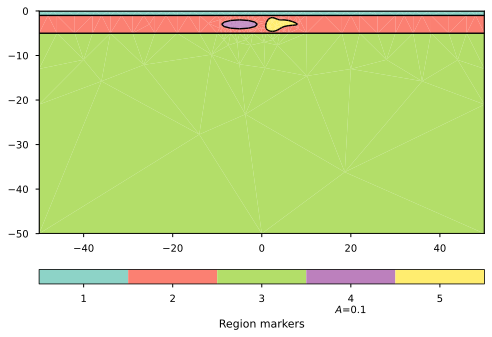

In [58]:
pg.show(geom)

## Synthetic data generation
Create a Dipole Dipole ('dd') measuring scheme with 21 electrodes.



In [59]:
scheme = ert.createData(elecs=np.linspace(start=-15, stop=15, num=21),
                        schemeName='dd')

Put all electrode (aka sensors) positions into the PLC to enforce mesh
refinement. Due to experience, its convenient to add further refinement
nodes in a distance of 10% of electrode spacing to achieve sufficient
numerical accuracy.



(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7f6984151c40>)

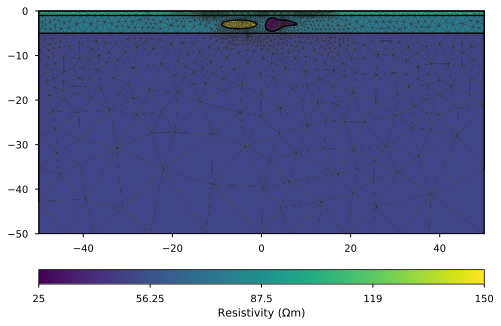

In [60]:
for p in scheme.sensors():
    geom.createNode(p)
    geom.createNode(p - [0, 0.1])

# Create a mesh for the finite element modelling with appropriate mesh quality.
mesh = mt.createMesh(geom, quality=34)

# Create a map to set resistivity values in the appropriate regions
# [[regionNumber, resistivity], [regionNumber, resistivity], [...]
rhomap = [[1, 100.],
          [2, 75.],
          [3, 50.],
          [4, 150.],
          [5, 25]]

# Take a look at the mesh and the resistivity distribution
pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True)

Perform the modeling with the mesh and the measuring scheme itself
and return a data container with apparent resistivity values,
geometric factors and estimated data errors specified by the noise setting.
The noise is also added to the data. Here 1% plus 1µV.
Note, we force a specific noise seed as we want reproducable results for
testing purposes.



In [61]:
data = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

18/12/22 - 00:18:29 - pyGIMLi - INFO - Calculate geometric factors.
18/12/22 - 00:18:29 - pyGIMLi - INFO - 0.13172095457607066 956.0725038881354


Found: export BERTTHREADS=8
ModellingBase::setMesh() copying new mesh ... Found datafile: 21 electrodes
Found: 21 free-electrodes
rMin = 0.75, rMax = 60
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.026 s
FOP updating mesh dependencies ... 0 s
relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.010000294838286121 : 0.01056761917552525
Obtaining geometric factors (analytical)
Calculating response for model: min = 25 max = 150
Allocating memory for primary potential...... 0.001

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.279s
Response: min = 43.6475 max = 102.718 mean = 71.3742
Reciprocity rms(modelReciprocity) 0.140597%, max: 0.449979%


18/12/22 - 00:18:29 - pyGIMLi - INFO - Simulated data Data: Sensors: 21 data: 171, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
18/12/22 - 00:18:29 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
18/12/22 - 00:18:29 - pyGIMLi - INFO - Simulated rhoa (min/max) 42.792496044211 104.19891011722967
18/12/22 - 00:18:29 - pyGIMLi - INFO - Selected data noise %(min/max) 1.0000294838286121 1.056761917552525


Optional: you can filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



18/12/22 - 00:18:29 - pyGIMLi - INFO - Filtered rhoa (min/max) 42.792496044211 104.19891011722967


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x7f6985a8b790>)

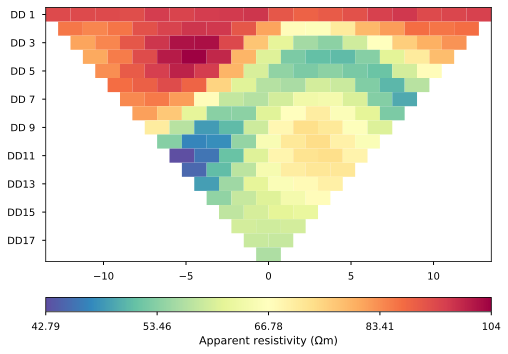

In [62]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('simple.dat')

# You can take a look at the data
ert.show(data)

## Inversion with the ERTManager
Initialize the ERTManager, e.g. with a data container or a filename.



In [63]:
mgr = ert.ERTManager('simple.dat')

Run the inversion with the preset data. The Inversion mesh will be created
with default settings.



In [64]:
inv = mgr.invert(lam=20, verbose=True)

18/12/22 - 00:18:30 - pyGIMLi - INFO - Found 2 regions.
18/12/22 - 00:18:30 - pyGIMLi - INFO - Region with smallest marker (1) set to background
18/12/22 - 00:18:30 - pyGIMLi - INFO - Creating forward mesh from region infos.
18/12/22 - 00:18:30 - pyGIMLi - INFO - Creating refined mesh (P2) to solve forward task.
18/12/22 - 00:18:30 - pyGIMLi - INFO - Use median(data values)=67.9439561191829
18/12/22 - 00:18:30 - pyGIMLi - INFO - Created startmodel from forward operator: 287 [67.9439561191829,...,67.9439561191829]
18/12/22 - 00:18:30 - pyGIMLi - INFO - Starting inversion.


Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  0

Writing vertices.
Writing triangles.
Writing segments.
Writing edges.

Output milliseconds:  0
Total running milliseconds:  0

Statistics:

  Input vertices: 49
  Input segments: 50
  Input holes: 0

  Mesh vertices: 266
  Mesh triangles: 456
  Mesh edges: 721
  Mesh exterior boundary edges: 74
  Mesh interior boundary edges: 15
  Mesh subsegments (constrained edges): 89

min/max(dweight) = 94.6287/99.9971
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x7f69859b8e50>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x7f69859b8720>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x7f69859b8860>
min/max (data): 42.79/10

Let the ERTManger show you the model of the last successful run and how it
fits the data. Shows data, model response, and model.



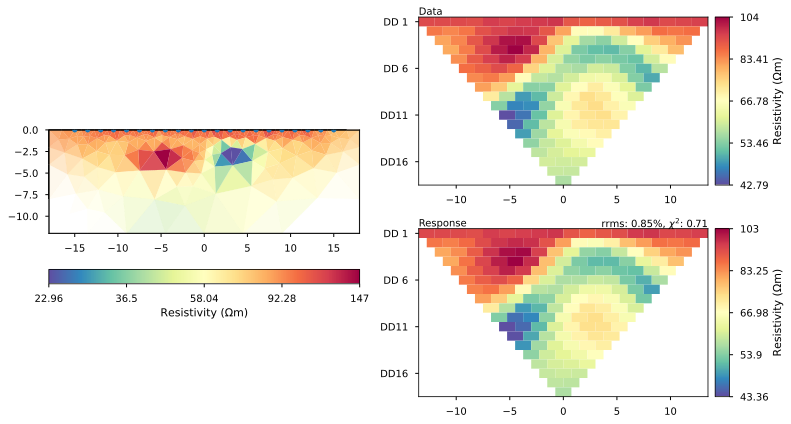

In [65]:
mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later

## Visualization
You can of course get access to mesh and model and plot them for your own.
Note that the cells of the parametric domain of your mesh might be in
a different order than the values in the model array if regions are used.
The manager can help to permutate them into the right order.



18/12/22 - 00:18:31 - pyGIMLi - INFO - Inversion stopped with chi² = 0.706


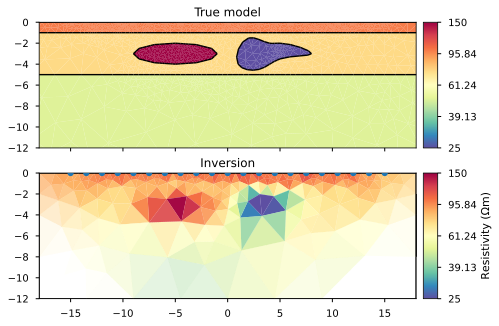

In [66]:
pg.info('Inversion stopped with chi² = {0:.3}'.format(mgr.inv.chi2()))

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True, figsize=(8,5))

pg.show(mesh, rhomap, ax=ax1, hold=True, cMap="Spectral_r", logScale=True,
        orientation="vertical", cMin=25, cMax=150)
mgr.showResult(ax=ax2, cMin=25, cMax=150, orientation="vertical")

labels = ["True model", "Inversion"]
for ax, label in zip([ax1, ax2], labels):
    ax.set_xlim(mgr.paraDomain.xmin(), mgr.paraDomain.xmax())
    ax.set_ylim(mgr.paraDomain.ymin(), mgr.paraDomain.ymax())
    ax.set_title(label)

# IP modeling and inversion